In [1]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_json("renttherunway_final_data.json", lines=True)

In [3]:
import missingno

<AxesSubplot:>

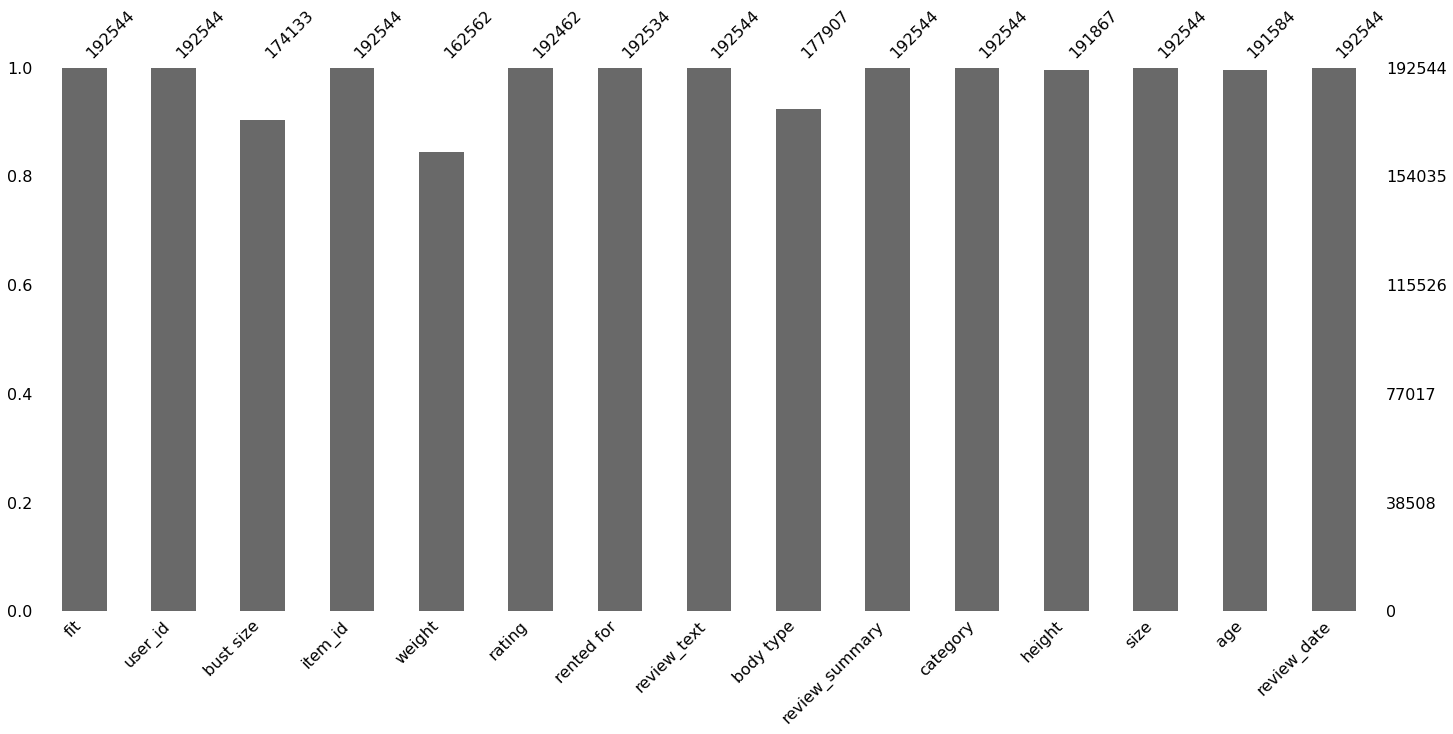

In [4]:
missingno.bar(df)

In [5]:
df.dropna(inplace=True)

In [6]:
df.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0,"June 18, 2013"
3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34.0,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27.0,"September 26, 2016"
5,fit,734848,32b,364092,138lbs,8.0,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,dress,"5' 8""",8,45.0,"April 30, 2016"


## Defining Baseline Model

### 3 baseline models to understand the accuracy of fit

#### 1st - Use numerical features where fit variable is fit and predict size using linear regression
#### 2nd - Generate random size measurements
#### 3rd - Predict last size of the user

In [7]:
# Model 1 - Use numerical features where fit variable is fit and predict size using linear regression

In [8]:
# Subsetting database where fit variable is fit

baseline_df = df[df['fit']== 'fit']
df.shape

(146381, 15)

In [9]:
# Selecting numerical features

# Independent features to be selected are 'bust_size', 'weight', 'rating', 'body_type', 'height', and 'age'
# Dependent feature will be 'size'

#Subsetting df to contain above mentioned variables

baseline_df = baseline_df[['bust size', 'weight', 'rating', 'body type', 'height', 'size', 'age']]
baseline_df.reset_index(inplace=True)
baseline_df.drop(columns='index', inplace=True)
baseline_df.head()

,bust size,weight,rating,body type,height,size,age
0,34d,137lbs,10.0,hourglass,"5' 8""",14,28.0
1,34b,132lbs,10.0,straight & narrow,"5' 6""",12,36.0
2,34c,135lbs,8.0,pear,"5' 5""",8,34.0
3,34b,145lbs,10.0,athletic,"5' 9""",12,27.0
4,32b,138lbs,8.0,athletic,"5' 8""",8,45.0


In [10]:
# Checking unique values in each column

baseline_df.nunique()

bust size     98
weight       181
rating         5
body type      7
height        23
size          56
age           80
dtype: int64

In [11]:
# Checking data types

baseline_df.dtypes

bust size     object
weight        object
rating       float64
body type     object
height        object
size           int64
age          float64
dtype: object

#### We observe that 'bust_size', 'weight', 'body_type', and 'height' are not in numerical format. Thus, data transformation is required.

### Data Preprocessing

In [12]:
# converting bust_size into numerical format
# understanding the data
bust_size_df = baseline_df[['bust size']]
bust_size_df.head()

# spliting bust size into 'band_size' and 'cup_volume'
band_size = []
cup_volume = []
for index,label in bust_size_df.iterrows():
    band_size.append(re.findall("[0-9][0-9]", label['bust size']))
    cup_volume.append(re.split("[0-9][0-9]", label['bust size'])[1])
band_size_df = pd.DataFrame(np.array(band_size), columns=['bust_band_size'])
cup_volume_df = pd.DataFrame(np.array(cup_volume), columns=['bust_cup_volume'])
baseline_df = pd.concat([baseline_df, band_size_df, cup_volume_df], axis = 1)

#convert cup_volume to numeric
unique_cup_volume = pd.DataFrame(baseline_df['bust_cup_volume'].sort_values().unique(), columns=['bust_cup_volume'])
unique_cup_volume['bust_cup_volume_numeric'] = unique_cup_volume.reset_index()['index'] + 1
baseline_df = pd.merge(baseline_df,unique_cup_volume, on='bust_cup_volume', how='left')

#drop original columns
baseline_df.drop(columns=['bust size', 'bust_cup_volume'], inplace=True)

baseline_df.head()

,weight,rating,body type,height,size,age,bust_band_size,bust_cup_volume_numeric
0,137lbs,10.0,hourglass,"5' 8""",14,28.0,34,5
1,132lbs,10.0,straight & narrow,"5' 6""",12,36.0,34,3
2,135lbs,8.0,pear,"5' 5""",8,34.0,34,4
3,145lbs,10.0,athletic,"5' 9""",12,27.0,34,3
4,138lbs,8.0,athletic,"5' 8""",8,45.0,32,3


In [13]:
# converting weight into numeric data
weight = []
for index,label in baseline_df.iterrows():
    weight.append(re.split("lbs", label['weight'])[0])
weight_df = pd.DataFrame(np.array(weight), columns = ['weight_numeric'])

#merge numeric weight entry
baseline_df = pd.concat([baseline_df,weight_df], axis=1)

#drop original columns
baseline_df.drop(columns=['weight'], inplace=True)
baseline_df.head()

,rating,body type,height,size,age,bust_band_size,bust_cup_volume_numeric,weight_numeric
0,10.0,hourglass,"5' 8""",14,28.0,34,5,137
1,10.0,straight & narrow,"5' 6""",12,36.0,34,3,132
2,8.0,pear,"5' 5""",8,34.0,34,4,135
3,10.0,athletic,"5' 9""",12,27.0,34,3,145
4,8.0,athletic,"5' 8""",8,45.0,32,3,138


In [14]:
# define function to convert height from feet and inches to inches
r = re.compile(r"([0-9]+)' ([0-9]*\.?[0-9]+)\"")
def get_inches(el):
    m = r.match(el)
    if m == None:
        return float('NaN')
    else:
        return int(m.group(1))*12 + float(m.group(2))

#convert height from feet and inches to inches
height=[]
for index,label in baseline_df.iterrows():
    height.append(get_inches(label['height']))
height_df = pd.DataFrame(np.array(height), columns = ['height_inches'])

#merge numeric weight entry
baseline_df = pd.concat([baseline_df,height_df], axis=1)

#drop original columns
baseline_df.drop(columns=['height'], inplace=True)
baseline_df.head()    

,rating,body type,size,age,bust_band_size,bust_cup_volume_numeric,weight_numeric,height_inches
0,10.0,hourglass,14,28.0,34,5,137,68.0
1,10.0,straight & narrow,12,36.0,34,3,132,66.0
2,8.0,pear,8,34.0,34,4,135,65.0
3,10.0,athletic,12,27.0,34,3,145,69.0
4,8.0,athletic,8,45.0,32,3,138,68.0


In [15]:
#check data types and convert columns to numeric data type
cols = ['rating', 'size', 'bust_band_size', 'bust_cup_volume_numeric', 'weight_numeric', 'height_inches']
baseline_df[cols] = baseline_df[cols].apply(pd.to_numeric)
baseline_df.dtypes

rating                     float64
body type                   object
size                         int64
age                        float64
bust_band_size               int64
bust_cup_volume_numeric      int64
weight_numeric               int64
height_inches              float64
dtype: object

In [16]:
# converting body_type variable to dummies
baseline_df = pd.get_dummies(baseline_df, drop_first=True)
baseline_df.head()

,rating,size,age,bust_band_size,bust_cup_volume_numeric,weight_numeric,height_inches,body type_athletic,body type_full bust,body type_hourglass,body type_pear,body type_petite,body type_straight & narrow
0,10.0,14,28.0,34,5,137,68.0,0,0,1,0,0,0
1,10.0,12,36.0,34,3,132,66.0,0,0,0,0,0,1
2,8.0,8,34.0,34,4,135,65.0,0,0,0,1,0,0
3,10.0,12,27.0,34,3,145,69.0,1,0,0,0,0,0
4,8.0,8,45.0,32,3,138,68.0,1,0,0,0,0,0


### EDA 

<AxesSubplot:>

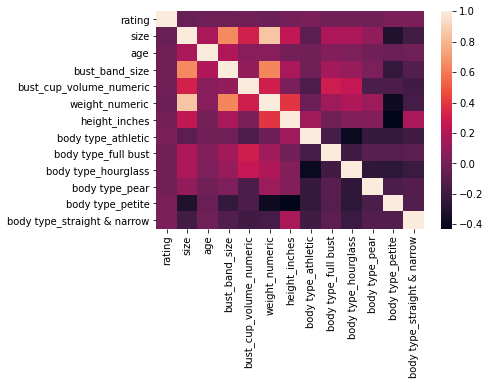

In [17]:
sns.heatmap(baseline_df.corr())

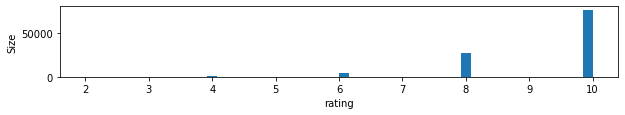

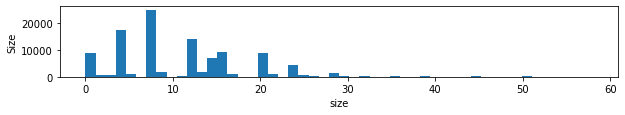

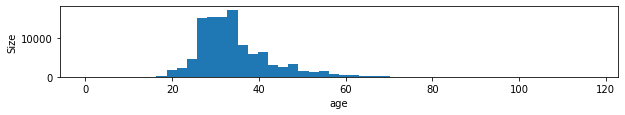

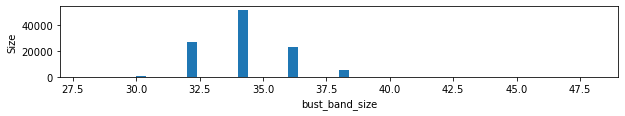

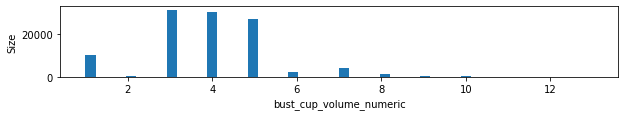

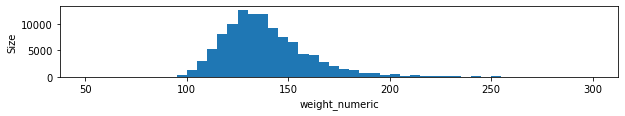

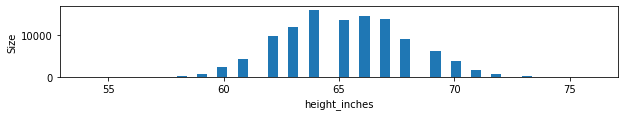

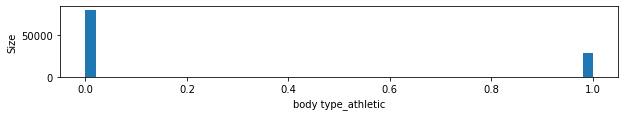

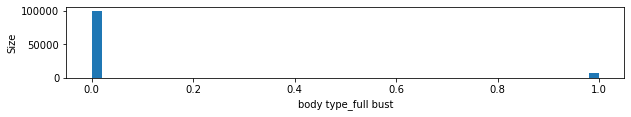

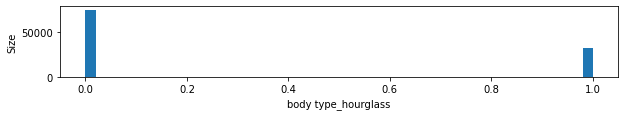

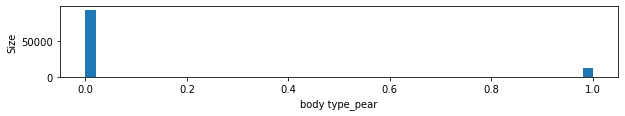

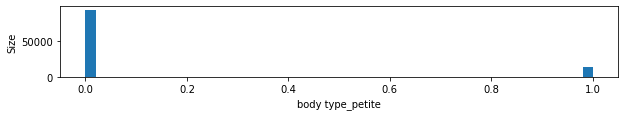

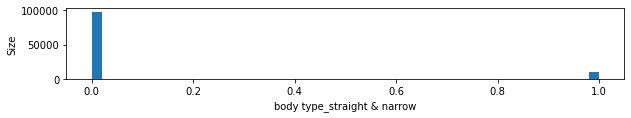

In [18]:
y=1
for column in baseline_df.columns:
    plt.figure(figsize=(10,20))
    plt.subplot(len(baseline_df.columns), 1, y)
    plt.hist(baseline_df[column], bins=50)
    plt.xlabel(column)
    plt.ylabel('Size')
    y=y+1

### Data Modeling

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

#### Linear Regression

In [20]:
# Define X variables
X = baseline_df.drop(columns=['size'])
y = baseline_df[['size']]

In [21]:
# perform train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

In [22]:
#model training and prediction
lr = LinearRegression()
lr.fit(X_train, y_train)

#predicting the labels 
y_pred = lr.predict(X_test)
r2_score(y_pred, y_test)

0.6968166192266123

In [23]:
#Model Summary 
import statsmodels.api as sm
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   size   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                 3.033e+04
Date:                Sat, 12 Feb 2022   Prob (F-statistic):               0.00
Time:                        17:48:22   Log-Likelihood:            -2.9371e+05
No. Observations:              107733   AIC:                         5.875e+05
Df Residuals:                  107720   BIC:                         5.876e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

#### Logistic Regression

In [24]:
# Define X variables
X = baseline_df.drop(columns=['size'])
y = baseline_df['size']

In [25]:
# perform train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

In [26]:
# model training and prediction
lr = LogisticRegression(multi_class='multinomial')

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

r2_score(y_pred, y_test)

/Users/niteshwagh/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.39577503208113496

### Scaling features 

In [27]:
from sklearn.preprocessing import MinMaxScaler

In [30]:
ms = MinMaxScaler()

In [57]:
# Define X variables
X = baseline_df.drop(columns=['size'])
y = baseline_df[['size']]

In [59]:
X[X.columns] = ms.fit_transform(X[X.columns])
y[y.columns] = ms.fit_transform(y[y.columns])

<ipython-input-59-c50688930cc4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y.columns] = ms.fit_transform(y[y.columns])
/Users/niteshwagh/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [62]:
y

,size
0,0.241379
1,0.206897
2,0.137931
3,0.206897
4,0.137931
...,...
107728,0.137931
107729,0.068966
107730,0.137931
107731,0.275862


In [60]:
# perform train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

In [69]:
y_test

,size
48723,0.137931
103001,0.068966
63397,0.017241
40305,0.344828
13882,0.672414
...,...
97138,0.206897
84180,0.017241
62066,0.137931
91160,0.137931


In [65]:
# model training and prediction
lr = LinearRegression()

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

r2_score(y_pred, y_test)

0.6968166192266111

In [70]:
y_pred

array([[0.19058268],
       [0.11986848],
       [0.11127514],
       ...,
       [0.25826727],
       [0.07477153],
       [0.31384508]])

In [71]:
y_test

,size
48723,0.137931
103001,0.068966
63397,0.017241
40305,0.344828
13882,0.672414
...,...
97138,0.206897
84180,0.017241
62066,0.137931
91160,0.137931
